As usual we must **first install the dependecies**. We install *pmdarima* as we will use it to infer the optimal ARIMA parameters. We will also see another way of doing it as comparison.

In [ ]:
!python3 -m pip install pmdarima # !pip3 install pdarima does not work in colab for some reason

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 32.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


Next, let us **import the required libraries**:

In [ ]:
from google.colab import files # we use this to handle IO as data is stored in files

# some libraries for array and data manipulation
import pandas as pd
import numpy as np

# useful libraries for error metrics and ML methods
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# some mathematical utility functions required in our code
import math
from math import sqrt

import pmdarima as pm # we use this for the auto_arima function to determine the optimal ARIMA parameters
from statsmodels.tsa.arima.model import ARIMA # we use this for the classic ARIMA function

import matplotlib.pyplot as plt # we use this for plotting the results



Now that everything is set up let us **upload the test files**. We will use two samples:

*  **Individual residential customers**. Subset of the [SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households). The dataset contains consumption (sampled at 30-minute intervals) for 39 residential customers between 01/01/2013 and 31/01/2013;
*   **Building level consumption data from a microgrid**. The dataset contains consumption (sampled at 15-minute intervals) for 33 buildings between 2/23/2013 and 3/23/2013 and can be downloaded from [here](https://saveawatthour.com/wp-content/uploads/2021/11/test-cleaned.csv).

**We use these different datasets to show the impact data has on the outcome of prediction methods**. As a data scientist working on smart grids or any other field for that matter understanding your data is of utmost importance. **While in school you may learn about various forecasting methods the choice is not driven by what you know or how comfortable working it you are, but rather by what is most suited for the particular time series data you want to analyze**.

In previous posts we have looked at [cleaning](https://saveawatthour.com/index.php/2021/07/15/cleaning-up-smart-grid-data-with-examples/) and performing [simple analytics](https://saveawatthour.com/index.php/2021/11/21/simple-analytics-with-examples/) on the data to discover some of its properties. Next we will apply simple time series forecast methods on our data.

In [ ]:
# Let us upload our to files (in this example they are named residential-kwh.csv and buildings-kwh.csv)
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
    name=fn, length=len(uploaded[fn])))

# Next we read their content in two dataframes
raw_residential_df = pd.read_csv('residential-kwh.csv',',')
raw_buildings_df = pd.read_csv('buildings-kwh.csv',',')

# We must convert the text in the csv to datetime format
raw_residential_df['DateTime']= pd.to_datetime(raw_residential_df['DateTime'], infer_datetime_format=True)
raw_buildings_df['DateTime']= pd.to_datetime(raw_buildings_df['DateTime'], infer_datetime_format=True)

Saving buildings-kwh.csv to buildings-kwh.csv
Saving residential-kwh.csv to residential-kwh.csv
User uploaded file "buildings-kwh.csv" with length 374199 bytes
User uploaded file "residential-kwh.csv" with length 365544 bytes


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


Show the residential data:

In [ ]:
raw_residential_df

,DateTime,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,2013-01-01 00:00:00,0.219,1.966,0.000,0.000,0.111,0.311,0.187,0.473,0.056,...,0.037,0.048,0.149,0.152,0.046,0.346,0.117,0.549,0.300,0.591
1,2013-01-01 00:30:00,0.241,1.922,0.000,0.000,0.176,0.349,0.191,0.479,0.040,...,0.029,0.066,0.162,0.194,0.045,0.380,0.129,0.578,0.310,0.583
2,2013-01-01 01:00:00,0.191,1.808,0.000,0.000,0.147,0.284,0.131,0.472,0.049,...,0.044,0.050,0.186,0.172,0.030,0.343,0.114,0.610,0.229,0.610
3,2013-01-01 01:30:00,0.235,0.795,0.158,0.000,0.093,0.136,0.146,0.473,0.143,...,0.026,0.059,0.141,0.157,0.017,0.365,0.133,0.503,0.190,1.167
4,2013-01-01 02:00:00,0.182,1.235,0.000,0.000,0.088,0.140,0.115,0.464,0.380,...,0.021,0.051,0.214,0.096,0.017,0.341,0.124,0.510,0.199,0.843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,2013-01-31 21:30:00,0.250,0.187,0.000,0.085,0.135,0.174,0.133,0.266,0.423,...,0.143,0.081,0.574,0.201,0.152,1.077,0.621,0.772,0.964,1.056
1484,2013-01-31 22:00:00,0.240,0.138,0.001,0.081,0.178,0.205,0.135,0.254,0.339,...,0.136,0.066,0.422,0.150,0.123,1.240,0.287,0.757,0.365,0.836
1485,2013-01-31 22:30:00,0.281,0.083,0.000,0.052,0.141,0.212,0.149,0.255,0.327,...,0.147,0.101,0.481,0.144,0.178,1.396,0.345,0.932,0.491,1.059
1486,2013-01-31 23:00:00,0.248,0.099,0.000,0.032,0.359,0.165,0.148,0.332,0.131,...,0.181,0.057,0.448,0.136,0.155,0.981,0.265,0.791,0.780,1.058


Show the building data:

In [ ]:
raw_buildings_df

,DateTime,0,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,2013-02-23 16:30:00,2.13,25.72,18,27,17,38,28,16,17,...,3,2,2.88,16,3.40,83,29,23.96,49.21,62.34
1,2013-02-23 16:45:00,2.13,22.23,14,28,17,37,28,16,17,...,3,2,2.95,14,3.44,77,28,25.29,49.23,59.68
2,2013-02-23 17:00:00,2.10,21.68,16,29,17,37,26,16,17,...,2,2,2.92,14,3.29,75,29,25.49,50.96,57.18
3,2013-02-23 17:15:00,2.98,22.62,17,15,16,37,29,17,17,...,3,3,2.66,13,3.24,74,27,26.55,46.74,56.17
4,2013-02-23 17:30:00,3.59,23.38,19,14,13,36,26,17,18,...,3,2,2.88,13,3.29,76,23,25.46,50.63,57.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,2013-03-23 22:45:00,2.35,16.73,22,11,19,31,29,13,13,...,2,3,2.00,8,2.12,117,18,24.10,43.87,72.16
2700,2013-03-23 23:00:00,2.21,17.13,18,12,19,34,29,14,14,...,2,2,1.74,8,2.20,115,18,24.12,43.96,69.81
2701,2013-03-23 23:15:00,2.24,20.42,16,12,19,33,27,14,13,...,2,1,1.63,7,2.07,117,19,24.03,44.62,69.98
2702,2013-03-23 23:30:00,2.22,16.42,20,12,19,31,29,13,14,...,2,2,1.45,8,2.18,112,18,24.12,44.14,69.92


# Error metrics
Before we can start forecasting we must first define some **forecast error metrics**. I have widely used **[MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)** and **wMAPE** for time series forecast but other like RMSE can also be used. To understand the differences between them have a look at this [post](https://www.baeldung.com/cs/mape-vs-wape-vs-wmape):

In [ ]:
def wMAPE(y_actual, y_predicted):
  return np.sum(np.abs((y_actual - y_predicted))) / np.sum(np.abs(y_actual)) * 100

def RMSE (y_actual, y_predicted):
  return sqrt(mean_squared_error(y_actual, y_predicted))

#Forecast methods
It may come as a suprise for some, but in smart grid time series analysis *simple* methods work quite well. By *simple* I refer mostly to methods other than neural networks that work as black boxes and are hard to interpret (i.e., the output is hard to be explained). I do not refer here to complexity as some such as choosing the best ARIMA model require considerable time.

A **sliding window** approach is taken for all methods as it reflects real-life scenarios where new data is constantly injected and the next *k* future values must be forecasted.

## Same Time and Day of Week
The simplest forecast method is to assume that **consumption at a certain time of day is equal to the consumption a week before at the same time**:

In [ ]:
def SameTimeAndDOW(y, pointsInWeek): # a week has 2 x 24 x 7 = 336 points for customers and 4 x 24 x 7 = 672 points for buildings
  prediction_list = list()
  for index in range(pointsInWeek, len(y)):
    prediction_list.append(y[index - pointsInWeek])

  # calculate out of sample error
  rmse_score = RMSE(y[pointsInWeek:], (prediction_list))
  mape_score = wMAPE(y[pointsInWeek:], (prediction_list))

  # return both error scores
  return mape_score, rmse_score

## Linear regression

The next method we test is the linear regression. In this model **we assume the linearity (for a certain time span) of the time series**. The model takes as input the *historical window* from which it learns the model, and the *prediction window*. In our case both contain lists of sizes equal to used past values and future predicted values.

In this model choosing the size of both the historical and the prediction windows impacts the error of the model. [A careful analysis is needed](https://saveawatthour.com/index.php/2021/11/21/simple-analytics-with-examples/**bold text**).

In [ ]:
def LinearRegressionSlidingWindow(x, y, window_size, prediction_size): # window size = historical window; prediction_size = size of future prediction
  r_scores = []
  mape_scores = []
  rmse_scores = []

  lrm = LinearRegression()
  for index in range(0, len(x), window_size):
    # Split data into training and testing: x represents the time coordinate and y the energy consumption
    x_train, x_test = x[index:index + window_size], x[index + window_size: index + window_size + prediction_size]
    y_train, y_test = y[index:index + window_size], y[index + window_size: index + window_size + prediction_size]

    if (len(x_test) > 0 and len(y_test) > 0):
      model_fit = lrm.fit(x_train, y_train)

      r_score = model_fit.score(x_test, y_test)
      r_scores.append(r_score)

      prediction = model_fit.predict(x_test)

      # calculate out of sample error
      rmse_score = RMSE(y_test, (prediction))
      mape_score = wMAPE(y_test, (prediction))
      rmse_scores.append(rmse_score)
      mape_scores.append(mape_score)

  # return a list of error scores for each error metric. These can be later averaged to get a single value for the dataset
  return mape_scores, rmse_scores

##Regression Trees
This model takes as parameter the *historical window* (assumed in our case to be equal to the *forecast window*). The value you use impacts the forecast error. In general (and this is true for all forecast algorithms) the larger the prediction window the greater the error of the model. This is normal as the more you predict into the future the greater the variability and uncertainty of the variables. Basically, it means that **the accuracy of the data we currently have decreases as we extend the forecast range**.

In [ ]:
from sklearn import tree

def RegressionTreeSlidingWindow(x, y, window_size):
  predictions = list()

  regressor = DecisionTreeRegressor(random_state=0)
  for index in range(window_size, len(x), window_size):
    x_train = x[0:index]
    y_train = y[0:index]

    model_fit = regressor.fit(x_train,y_train)
    yhat = model_fit.predict(x[index: index + window_size])
    predictions.extend(yhat)

  # calculate out of sample error
  rmse_score = RMSE(y[0:len(predictions)], predictions)
  mape_score = wMAPE(y[0:len(predictions)], predictions)

  # Uncheck below if you want to see the regression tree
  #plt.figure(figsize=(30,30))
  #tree.plot_tree(model_fit, max_depth=3, fontsize=14, feature_names=['time index'], class_names=True)
  #plt.show()

  # return both error scores
  return mape_score, rmse_score

##ARIMA

For this model we are using **two approaches** to find the optimal (p, d, q) parameters.

In [ ]:
def ARIMASlidingWindow(x, arima_order, window_size, prediction_ds_size):

  assert window_size < prediction_ds_size, "Incorrect data"

  # prepare training dataset
  train_size = int(len(x) * 0.75)
  train, test = x[0:train_size], x[train_size:]
  history = [t for t in train]

  # make predictions by using a sliding window
  predictions = list()
  for t in range(0, prediction_ds_size, window_size):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    #yhat = model_fit.forecast()[0]
    yhat = model_fit.predict(len(history),len(history)+window_size) # out of sample forecast
    predictions.extend(yhat)
    history.extend(test[t:t+window_size])

  # calculate out of sample error
  rmse_score = RMSE(test[:prediction_ds_size], predictions[:prediction_ds_size])
  mape_score = wMAPE(test[:prediction_ds_size], predictions[:prediction_ds_size])

  # return both error scores
  return mape_score, rmse_score

The first method relies on the *statsmodels.tsa.arima.model.ARIMA* to do a **parameter sweep** over a list of possible (p, d, q) values returning the configuration that provided the lowest MAPE score. This configuration will be used for the actual out of sample forecasts.

In [ ]:
def ARIMAFindBest(dataset, p_values, d_values, q_values, window_size, prediction_ds_size):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None

  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          mape, rmse = ARIMASlidingWindow(dataset, order, window_size, prediction_ds_size)
          if mape < best_score:
            best_score, best_cfg = mape, order
        except:
          continue

  print('Best ARIMA%s MAPE=%.3f' % (best_cfg, best_score))
  # return best ARIMA configuration parameters. These can later be used as parameters to the previous ARIMASlidingWindow method
  return best_cfg

The second method uses *pmdarima.auto_arima* to automatically find the best (p, d q) configuration and return the model associated to it. The [ADF](https://saveawatthour.com/index.php/2021/11/21/simple-analytics-with-examples/) test is used in our case.

*I have observed that the auto_arima is not only slower but the configuration is outputs is sometimes worse than the best one found by the previous explicit brute force approach.*

In [ ]:
def ARIMAPredictUsingBestModel(x, window_size):
  train_size = int(len(x) * 0.75)
  train, test = x[0:train_size], x[train_size:]

  model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=8, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # assume no seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

  yhat, confint = model.predict(n_periods=window_size, return_conf_int=True)

  # calculate out of sample error
  rmse_score = RMSE(test[:window_size], yhat[:window_size])
  mape_score = wMAPE(test[:window_size], yhat[:window_size])

  # return both error scores
  return mape_score, rmse_score

## Test methods

Now we are ready to run each model on both datasets and compare the results.

I use a window size of 8 for the building dataset and 4 for the residential dataset to predict 2 hours ahead. This can vary but in general **shorter windows produce lower errors**.

For the DOW method the previous week's date is 672 steps before in the case of the building dataset and 336 for the residential dataset.

*NOTE: In this example, we do not store the RMSE of each forecast, focusing on MAPE instead.*

### Building **dataset**

In [ ]:
raw_buildings_df['Index'] = [i for i in range(len(raw_buildings_df['DateTime']))]
x = raw_buildings_df.loc[:,'Index'].values.reshape(-1,1)

mape_dow_list_b = list() # stores MAPE for DOW for each building
mape_lr_list_b = list() # stores MAPE for Linear Regression for each building
mape_rt_list_b = list() # stores MAPE for Regression Trees for each building
mape_arima_list_b = list() # stores MAPE for ARIMA for each building

# Iterate through each building
for i in range(0,33):

  # Forecast for each and store results in a list
  y = raw_buildings_df.loc[:,str(i)].values

  # Run the Same Time and Day of Week method
  mape, rmse = SameTimeAndDOW(y, 672)
  mape_dow_list_b.append(mape)

  # Run the linear regression method
  mape, rmse = LinearRegressionSlidingWindow(x, y, 8, 8)
  if (math.isinf(np.average(mape)) == False):
    mape_lr_list_b.append(np.average(mape))

  # Run Regression Tree method
  mape, rmse = RegressionTreeSlidingWindow(x, y, 8)
  mape_rt_list_b.append(mape)

  # Run ARIMA method
  mape, rmse = ARIMAPredictUsingBestModel(y, 8)
  mape_arima_list_b.append(mape)


### Residential dataset

In [ ]:
raw_residential_df['Index'] = [i for i in range(len(raw_residential_df['DateTime']))]
x = raw_residential_df.loc[:,'Index'].values.reshape(-1,1)

mape_dow_list_r = list() # stores MAPE for DOW for each residential customer
mape_lr_list_r = list() # stores MAPE for Linear Regression for each residential customer
mape_rt_list_r = list() # stores MAPE for Regression Trees for each residential customer
mape_arima_list_r = list() # stores MAPE for ARIMA for each residential customer

# Iterate through each residential customer
for i in range(0,38):

  # Forecast for each and store results in a list
  y = raw_residential_df.loc[:,str(i)].values

  # Run the Same Time and Day of Week method
  mape, rmse = SameTimeAndDOW(y, 336)
  mape_dow_list_r.append(mape)

  # Run the linear regression method
  mape, rmse = LinearRegressionSlidingWindow(x, y, 4, 4)
  if (math.isinf(np.average(mape)) == False):
    mape_lr_list_r.append(np.average(mape))

  # Run Regression Tree method
  mape, rmse = RegressionTreeSlidingWindow(x, y, 4)
  mape_rt_list_r.append(mape)

  # Run ARIMA method
  mape, rmse = ARIMAPredictUsingBestModel(y, 4)
  mape_arima_list_r.append(mape)

##Display results

Let us see the MAPE results for each forecast for both datasets:

In [ ]:
print (mape_dow_list_b)
print (mape_lr_list_b)
print (mape_rt_list_b)
print (mape_arima_list_b)

print (mape_dow_list_r)
print (mape_lr_list_r)
print (mape_rt_list_r)
print (mape_arima_list_r)

[18.483020527744067, 13.518364765113619, 11.399078750208114, 14.714483258903272, 18.58588513602313, 8.663430221839857, 13.783228874000434, 29.167268177662287, 16.0543886681264, 6.980613068471941, 28.717592903734516, 19.561983269516865, 18.955998606041707, 14.207809579339084, 38.37290304603365, 14.066421877568915, 21.61611270025622, 18.8728115545605, 5.981453430376473, 8.62242103341245, 8.006662052963057, 11.789879608728366, 39.4476698572101, 45.51362683438155, 16.509863429438543, 19.676704869644134, 17.97824020280976, 17.830745810868443, 18.676963350785343, 11.758116265158518, 54.45403813268208, 13.96325214491769, 62.48309075777742]
[22.902829110429664, 11.97524104921815, 13.852297916406846, 21.449995436227223, 11.20246800134516, 6.939088015612997, 20.627721223233017, 40.35404752359374, 10.324190091361505, 15.404415207328025, 27.824710087862528, 16.398511510516403, 20.789891783858973, 17.64008455469771, 29.06860063386395, 10.128473309907156, 26.799157957222924, 22.098041981771207, 16.2

Lists are not the best way to visualize results so let us build **histograms**. These are frequency tables that allow us the see the **error distribution**. In analyzing them we normally look at two things:

* **the spread of the histogram** which tells us the error range;
* **the highest colums** which tell us which error is most frequent.

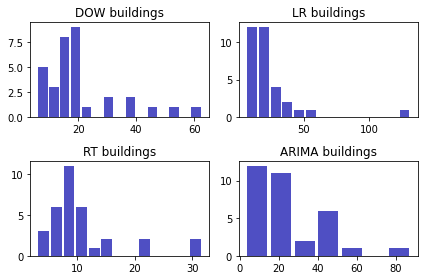

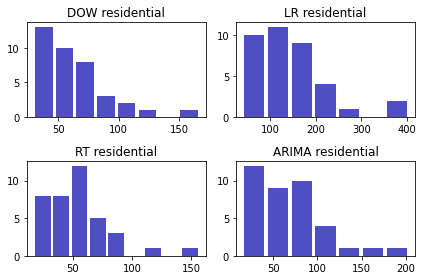

In [ ]:

fig_b = plt.figure()
dow = fig_b.add_subplot(2, 2, 1)
lr = fig_b.add_subplot(2, 2, 2)
rt = fig_b.add_subplot(2, 2, 3)
ar = fig_b.add_subplot(2, 2, 4)

dow.hist(x=mape_dow_list_b, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
dow.set_title('DOW buildings')
lr.hist(x=mape_lr_list_b, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
lr.set_title('LR buildings')
rt.hist(x=mape_rt_list_b, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
rt.set_title('RT buildings')
ar.hist(x=mape_arima_list_b, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
ar.set_title('ARIMA buildings')

fig_b.tight_layout()
plt.show()

fig_r = plt.figure()
dow = fig_r.add_subplot(2, 2, 1)
lr = fig_r.add_subplot(2, 2, 2)
rt = fig_r.add_subplot(2, 2, 3)
ar = fig_r.add_subplot(2, 2, 4)

dow.hist(x=mape_dow_list_r, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
dow.set_title('DOW residential')
lr.hist(x=mape_lr_list_r, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
lr.set_title('LR residential')
rt.hist(x=mape_rt_list_r, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
rt.set_title('RT residential')
ar.hist(x=mape_arima_list_r, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
ar.set_title('ARIMA residential')

fig_r.tight_layout()
plt.show()

Histograms are decent for a first look but I prefer using a **CDF** (Cumulative Distributed Function) to visualize the percentage of customers with a certain MAPE.

The x-axis contains the MAPE errors and the y-axis the percentage scaled between 0 and 1. For a specific point on the plotted curve you get the percentage of datapoints (the y-axis value) with MAPE less or equal to the value indicated on the x-axis.

**A method is better if its curve is to the left of the other.**

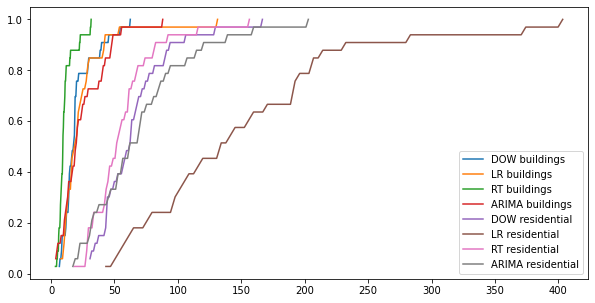

In [ ]:
# to simplify the code we'll use a dataframe to store and process our results
mape_df = pd.DataFrame(list(zip(mape_dow_list_b, mape_lr_list_b, mape_rt_list_b, mape_arima_list_b, mape_dow_list_r, mape_lr_list_r, mape_rt_list_r, mape_arima_list_r)),
                  columns =['DOW buildings', 'LR buildings', 'RT buildings', 'ARIMA buildings', 'DOW residential', 'LR residential', 'RT residential', 'ARIMA residential'])

plt.figure(figsize=(10, 5))

for column in mape_df:
  # getting data of the histogram
  count, bins_count = np.histogram(mape_df[column], bins=100)
  # finding the PDF of the histogram using count values
  pdf = count / sum(count)

  # using numpy np.cumsum to calculate the CDF
  cdf = np.cumsum(pdf)

  # plotting CDF
  plt.plot(bins_count[1:], cdf, label=column)
  plt.legend()

**In our case** the overall **hierarchy** would be:

1.   **RT buildings**
2.   DOW buildings
3.   LR buildings
4.   ARIMA buildings
5.   **RT residential**
6.   DOW residential
7.   ARIMA residential
8.   LR residential

A brief analysis derived from the plot tells us that:

* Linear Regression works better for buildings than for individual residences as they are less noisy (fluctuating). This means that for the residential dataset the method probably averages the consumption.

* Regression Trees are the best in both cases but for low MAPEs ($<$25) ARIMA outperforms them.

* For the building dataset there is no clear distinction between ARIMA, DOW, and LR for MAPES $<$20 (lines concide).

* The hierarchy is the same for the first 2 best methods for both datasets.

* MAPE errors are higher for the residential dataset.
